# Evaluation of Diagnostic Models

Welcome to the second assignment of course 1. In this assignment, we will be working with the results of the X-ray classification model we developed in the previous assignment. In order to make the data processing a bit more manageable, we will be working with a subset of our training, and validation datasets. We will also use our manually labeled test dataset of 420 X-rays.  

As a reminder, our dataset contains X-rays from 14 different conditions diagnosable from an X-ray. We'll evaluate our performance on each of these classes using the classification metrics we learned in lecture.

## Outline
Click on these links to jump to a particular section of this assignment!
- [1. Packages](#1)
- [2. Overview](#2)
- [3. Metrics](#3)
    - [3.1 True Positives, False Positives, True Negatives, and False Negatives](#3-1)
    - [3.2 Accuracy](#3-2)
    - [3.3 Prevalence](#3-3)
    - [3.4 Sensitivity and Specificity](#3-4)
    - [3.5 PPV and NPV](#3-5)
    - [3.6 ROC Curve](#3-6)
- [4. Confidence Intervals](#4)
- [5. Precision-Recall Curve](#5)
- [6. F1 Score](#6)
- [7. Calibration](#7)

**By the end of this assignment you will learn about:**

1. Accuracy
1. Prevalence
1. Specificity & Sensitivity
1. PPV and NPV
1. ROC curve and AUCROC (c-statistic)
1. Confidence Intervals

<a name='1'></a>
## 1. Packages

In this assignment, we'll make use of the following packages:
- [numpy](https://docs.scipy.org/doc/numpy/) is a popular library for scientific computing
- [matplotlib](https://matplotlib.org/3.1.1/contents.html) is a plotting library compatible with numpy
- [pandas](https://pandas.pydata.org/docs/) is what we'll use to manipulate our data
- [sklearn](https://scikit-learn.org/stable/index.html) will be used to measure the performance of our model


Run the next cell to import all the necessary packages as well as custom util functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  

import util

<a name='2'></a>
## 2. Overview

We'll go through our evaluation metrics in the following order.

- Metrics
  - TP, TN, FP, FN
  - Accuracy
  - Prevalence
  - Sensitivity and Specificity
  - PPV and NPV
  - AUC
- Confidence Intervals

Let's take a quick peek at our dataset. The data is stored in two CSV files called `train_preds.csv` and `valid_preds.csv`. We have precomputed the model outputs for our test cases. We'll work with these predictions and the true class labels throughout the assignment.

In [2]:
train_results = pd.read_csv("train_preds.csv")
valid_results = pd.read_csv("valid_preds.csv")

# the labels in our dataset
class_labels = ['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

# the labels for prediction values in our dataset
pred_labels = [l + "_pred" for l in class_labels]

Extract the labels (y) and the predictions (pred).

In [3]:
y = valid_results[class_labels].values
pred = valid_results[pred_labels].values

Run the next cell to view them side by side.

In [4]:
# let's take a peek at our dataset
valid_results[np.concatenate([class_labels, pred_labels])].head()

,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,...,Infiltration_pred,Mass_pred,Nodule_pred,Atelectasis_pred,Pneumothorax_pred,Pleural_Thickening_pred,Pneumonia_pred,Fibrosis_pred,Edema_pred,Consolidation_pred
0,0,0,0,0,0,0,0,0,0,0,...,0.256020,0.266928,0.312440,0.460342,0.079453,0.271495,0.276861,0.398799,0.015867,0.156320
1,0,0,0,0,1,0,1,0,0,0,...,0.382199,0.176825,0.465807,0.489424,0.084595,0.377318,0.363582,0.638024,0.025948,0.144419
2,0,0,0,0,0,0,0,0,0,0,...,0.427727,0.115513,0.249030,0.035105,0.238761,0.167095,0.166389,0.262463,0.007758,0.125790
3,0,0,0,0,0,0,0,0,0,0,...,0.158596,0.259460,0.334870,0.266489,0.073371,0.229834,0.191281,0.344348,0.008559,0.119153
4,0,0,0,0,0,0,0,0,0,0,...,0.536762,0.198797,0.273110,0.186771,0.242122,0.309786,0.411771,0.244666,0.126930,0.342409


To further understand our dataset details, here's a histogram of the number of samples for each label in the validation dataset:

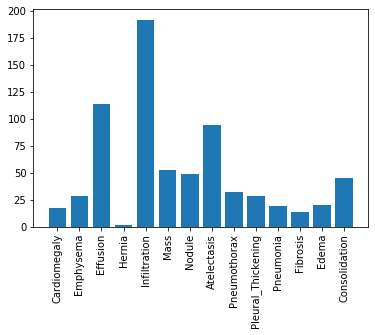

In [5]:
plt.xticks(rotation=90)
plt.bar(x = class_labels, height= y.sum(axis=0));

It seem like our dataset has an imbalanced population of samples. Specifically, our dataset has a small number of patients diagnosed with a `Hernia`.

<a name='3'></a>
## 3 Metrics

<a name='3-1'></a>
### 3.1 True Positives, False Positives, True Negatives, and False Negatives

The most basic statistics to compute from the model predictions are the true positives, true negatives, false positives, and false negatives. 

As the name suggests
- true positive (TP): The model classifies the example as positive, and the actual label also positive.
- false positive (FP): The model classifies the example as positive, **but** the actual label is negative.
- true negative (TN): The model classifies the example as negative, and the actual label is also negative.
- false negative (FN): The model classifies the example as negative, **but** the label is actually positive.

We will count the number of TP, FP, TN and FN in the given data.  All of our metrics can be built off of these four statistics. 

Recall that the model outputs real numbers between 0 and 1.
* To compute binary class predictions, we need to convert these to either 0 or 1. 
* We'll do this using a threshold value $th$.
* Any model outputs above $th$ are set to 1, and below $th$ are set to 0. 

All of our metrics (except for AUC at the end) will depend on the choice of this threshold. 

Fill in the functions to compute the TP, FP, TN, and FN for a given threshold below. 

The first one has been done for you.

In [6]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def true_positives(y, pred, th=0.5):
    """
    Count true positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TP (int): true positives
    """
    TP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    
    return TP

def true_negatives(y, pred, th=0.5):
    """
    Count true negatives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        TN (int): true negatives
    """
    TN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute TN
    TN = np.sum((y == 0 ) & (thresholded_preds == 0 ))
    
    ### END CODE HERE ###
    
    return TN

def false_positives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FP (int): false positives
    """
    FP = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1))
    
    ### END CODE HERE ###
    
    return FP

def false_negatives(y, pred, th=0.5):
    """
    Count false positives.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        FN (int): false negatives
    """
    FN = 0
    
    # get thresholded predictions
    thresholded_preds = pred >= th

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))
    
    ### END CODE HERE ###
    
    return FN

In [7]:
# Note: we must explicity import 'display' in order for the autograder to compile the submitted code
# Even though we could use this function without importing it, keep this import in order to allow the grader to work
from IPython.display import display
# Test
df = pd.DataFrame({'y_test': [1,1,0,0,0,0,0,0,0,1,1,1,1,1],
                   'preds_test': [0.8,0.7,0.4,0.3,0.2,0.5,0.6,0.7,0.8,0.1,0.2,0.3,0.4,0],
                   'category': ['TP','TP','TN','TN','TN','FP','FP','FP','FP','FN','FN','FN','FN','FN']
                  })

display(df)
#y_test = np.array([1, 0, 0, 1, 1])
y_test = df['y_test']

#preds_test = np.array([0.8, 0.8, 0.4, 0.6, 0.3])
preds_test = df['preds_test']

threshold = 0.5
print(f"threshold: {threshold}\n")

print(f"""Our functions calculated: 
TP: {true_positives(y_test, preds_test, threshold)}
TN: {true_negatives(y_test, preds_test, threshold)}
FP: {false_positives(y_test, preds_test, threshold)}
FN: {false_negatives(y_test, preds_test, threshold)}
""")

print("Expected results")
print(f"There are {sum(df['category'] == 'TP')} TP")
print(f"There are {sum(df['category'] == 'TN')} TN")
print(f"There are {sum(df['category'] == 'FP')} FP")
print(f"There are {sum(df['category'] == 'FN')} FN")

,y_test,preds_test,category
0,1,0.8,TP
1,1,0.7,TP
2,0,0.4,TN
3,0,0.3,TN
4,0,0.2,TN
5,0,0.5,FP
6,0,0.6,FP
7,0,0.7,FP
8,0,0.8,FP
9,1,0.1,FN


threshold: 0.5

Our functions calculated: 
TP: 2
TN: 3
FP: 4
FN: 5

Expected results
There are 2 TP
There are 3 TN
There are 4 FP
There are 5 FN


Run the next cell to see a summary of evaluative metrics for the model predictions for each class. 

In [8]:
util.get_performance_metrics(y, pred, class_labels)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,20,869,103,8,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,99,690,196,15,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,1,743,255,1,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,114,543,265,78,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,40,789,158,13,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,28,731,220,21,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,64,657,249,30,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,24,785,183,8,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


Right now it only has TP, TN, FP, FN. Throughout this assignment we'll fill in all the other metrics to learn more about our model performance.

<a name='3-2'></a>
### 3.2 Accuracy


Let's use a threshold of .5 for the probability cutoff for our predictions for all classes and calculate our model's accuracy as we would normally do in a machine learning problem. 

$$accuracy = \frac{\text{true positives} + \text{true negatives}}{\text{true positives} + \text{true negatives} + \text{false positives} + \text{false negatives}}$$

Use this formula to compute accuracy below:

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Remember to set the value for the threshold when calling the functions.</li>
</ul>
</p>

In [9]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    accuracy = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y, pred, th)   
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y,pred, th)

    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / ( TP + FP + TN + FN)
    
    ### END CODE HERE ###
    
    return accuracy

In [10]:
# Test
print("Test case:")

y_test = np.array([1, 0, 0, 1, 1])
print('test labels: {y_test}')

preds_test = np.array([0.8, 0.8, 0.4, 0.6, 0.3])
print(f'test predictions: {preds_test}')

threshold = 0.5
print(f"threshold: {threshold}")

print(f"computed accuracy: {get_accuracy(y_test, preds_test, threshold)}")

Test case:
test labels: {y_test}
test predictions: [0.8 0.8 0.4 0.6 0.3]
threshold: 0.5
computed accuracy: 0.6


#### Expected output:

```Python
test labels: {y_test}
test predictions: [0.8 0.8 0.4 0.6 0.3]
threshold: 0.5
computed accuracy: 0.6
```

Run the next cell to see the accuracy of the model output for each class, as well as the number of true positives, true negatives, false positives, and false negatives.

In [11]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,0.83,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,20,869,103,8,0.889,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,99,690,196,15,0.789,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,1,743,255,1,0.744,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,114,543,265,78,0.657,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,40,789,158,13,0.829,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,28,731,220,21,0.759,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,64,657,249,30,0.721,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,24,785,183,8,0.809,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


If we were to judge our model's performance based on the accuracy metric, we would say that our model is not very accurate for detecting the `Infiltration` cases (accuracy of 0.657) but pretty accurate for detecting `Emphysema` (accuracy of 0.889). 

**But is that really the case?...**

Let's imagine a model that simply predicts that any patient does **Not** have `Emphysema`, regardless of patient's measurements. Let's calculate the accuracy for such a model.

In [12]:
get_accuracy(valid_results["Emphysema"].values, np.zeros(len(valid_results)))

0.972

As you can see above, such a model would be 97% accurate! Even better than our deep learning based model. 

But is this really a good model? Wouldn't this model be wrong 100% of the time if the patient actually had this condition?

In the following sections, we will address this concern with more advanced model measures - **sensitivity and specificity** - that evaluate how well the model predicts positives for patients with the condition and negatives for cases that actually do not have the condition.

<a name='3-3'></a>
### 3.3 Prevalence
Another important concept is **prevalence**. 
* In a medical context, prevalence is the proportion of people in the population who have the disease (or condition, etc). 
* In machine learning terms, this is the proportion of positive examples. The expression for prevalence is:

$$prevalence = \frac{1}{N} \sum_{i} y_i$$

where $y_i = 1$ when the example is 'positive' (has the disease).

Let's measure prevalence for each disease:

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>
    You can use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html" > np.mean </a> to calculate the formula.</li>
    <li>Actually, the automatic grader is expecting numpy.mean, so please use it instead of using an equally valid but different way of calculating the prevalence. =) </li>
</ul>
</p>


In [13]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_prevalence(y):
    """
    Compute prevalence.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    prevalence = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    prevalence = np.mean(y)
    
    ### END CODE HERE ###
    
    return prevalence

In [14]:
# Test
print("Test case:\n")

y_test = np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1])
print(f'test labels: {y_test}')

print(f"computed prevalence: {get_prevalence(y_test)}")


Test case:

test labels: [1 0 0 1 1 0 0 0 0 1]
computed prevalence: 0.4


In [15]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,0.83,0.017,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,20,869,103,8,0.889,0.028,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,99,690,196,15,0.789,0.114,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,1,743,255,1,0.744,0.002,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,114,543,265,78,0.657,0.192,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,40,789,158,13,0.829,0.053,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,28,731,220,21,0.759,0.049,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,64,657,249,30,0.721,0.094,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,24,785,183,8,0.809,0.032,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,Not Defined,0.5


`Hernia` has a prevalence 0.002, which is the rarest among the studied conditions in our dataset.

<a name='3-4'></a>
### 3.4 Sensitivity and Specificity
<img src="sens_spec.png" width="30%">

Sensitivity and specificity are two of the most prominent numbers that are used to measure diagnostics tests.
- Sensitivity is the probability that our test outputs positive given that the case is actually positive.
- Specificity is the probability that the test outputs negative given that the case is actually negative. 

We can phrase this easily in terms of true positives, true negatives, false positives, and false negatives: 

$$sensitivity = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

$$specificity = \frac{\text{true negatives}}{\text{true negatives} + \text{false positives}}$$

Let's calculate sensitivity and specificity for our model:

In [16]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    sensitivity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FN using our previously defined functions
    TP = true_positives(y,pred, th)
    FN = false_negatives(y, pred, th)

    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP + FN)
    
    ### END CODE HERE ###
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    specificity = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FP using our previously defined functions
    TN = true_negatives(y,pred, th)
    FP = false_positives(y, pred, th)
    
    # use TN and FP to compute specificity 
    specificity = TN / (TN + FP)
    
    ### END CODE HERE ###
    
    return specificity

In [17]:
# Test
print("Test case")

y_test = np.array([1, 0, 0, 1, 1])
print(f'test labels: {y_test}\n')

preds_test = np.array([0.8, 0.8, 0.4, 0.6, 0.3])
print(f'test predictions: {preds_test}\n')

threshold = 0.5
print(f"threshold: {threshold}\n")

print(f"computed sensitivity: {get_sensitivity(y_test, preds_test, threshold):.2f}")
print(f"computed specificity: {get_specificity(y_test, preds_test, threshold):.2f}")

Test case
test labels: [1 0 0 1 1]

test predictions: [0.8 0.8 0.4 0.6 0.3]

threshold: 0.5

computed sensitivity: 0.67
computed specificity: 0.50


#### Expected output:

```Python
Test case
test labels: [1 0 0 1 1]

test predictions: [0.8 0.8 0.4 0.6 0.3]

threshold: 0.5

computed sensitivity: 0.67
computed specificity: 0.50

```

In [18]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,0.83,0.017,0.941,0.828,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Emphysema,20,869,103,8,0.889,0.028,0.714,0.894,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Effusion,99,690,196,15,0.789,0.114,0.868,0.779,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Hernia,1,743,255,1,0.744,0.002,0.5,0.744,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Infiltration,114,543,265,78,0.657,0.192,0.594,0.672,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Mass,40,789,158,13,0.829,0.053,0.755,0.833,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Nodule,28,731,220,21,0.759,0.049,0.571,0.769,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Atelectasis,64,657,249,30,0.721,0.094,0.681,0.725,Not Defined,Not Defined,Not Defined,Not Defined,0.5
Pneumothorax,24,785,183,8,0.809,0.032,0.75,0.811,Not Defined,Not Defined,Not Defined,Not Defined,0.5


Note that specificity and sensitivity do not depend on the prevalence of the positive class in the dataset. 
* This is because the statistics are only computed within people of the same class
* Sensitivity only considers output on people in the positive class
* Similarly, specificity only considers output on people in the negative class.

<a name='3-5'></a>
### 3.5 PPV and NPV

Diagnostically, however, sensitivity and specificity are not helpful. Sensitivity, for example, tells us the probability our test outputs positive given that the person already has the condition. Here, we are conditioning on the thing we would like to find out (whether the patient has the condition)!

What would be more helpful is the probability that the person has the disease given that our test outputs positive. That brings us to positive predictive value (PPV) and negative predictive value (NPV).

- Positive predictive value (PPV) is the probability that subjects with a positive screening test truly have the disease.
- Negative predictive value (NPV) is the probability that subjects with a negative screening test truly don't have the disease.

Again, we can formulate these in terms of true positives, true negatives, false positives, and false negatives: 

$$PPV = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$ 

$$NPV = \frac{\text{true negatives}}{\text{true negatives} + \text{false negatives}}$$


Let's calculate PPV & NPV for our model:

In [19]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    PPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TP and FP using our previously defined functions
    TP = true_positives(y,pred,th)
    FP = false_positives(y,pred,th)

    # use TP and FP to compute PPV
    PPV = TP / (TP + FP)
    
    ### END CODE HERE ###
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    NPV = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get TN and FN using our previously defined functions
    TN = true_negatives(y,pred,th)
    FN = false_negatives(y,pred,th)

    # use TN and FN to compute NPV
    NPV = TN / (TN + FN)
    
    ### END CODE HERE ###
    
    return NPV

In [20]:
# Test
print("Test case:\n")

y_test = np.array([1, 0, 0, 1, 1])
print(f'test labels: {y_test}')

preds_test = np.array([0.8, 0.8, 0.4, 0.6, 0.3])
print(f'test predictions: {preds_test}\n')

threshold = 0.5
print(f"threshold: {threshold}\n")

print(f"computed ppv: {get_ppv(y_test, preds_test, threshold):.2f}")
print(f"computed npv: {get_npv(y_test, preds_test, threshold):.2f}")

Test case:

test labels: [1 0 0 1 1]
test predictions: [0.8 0.8 0.4 0.6 0.3]

threshold: 0.5

computed ppv: 0.67
computed npv: 0.50


#### Expected output:

```Python
Test case:

test labels: [1 0 0 1 1]
test predictions: [0.8 0.8 0.4 0.6 0.3]

threshold: 0.5

computed ppv: 0.67
computed npv: 0.50
```

In [21]:
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,0.83,0.017,0.941,0.828,0.086,0.999,Not Defined,Not Defined,0.5
Emphysema,20,869,103,8,0.889,0.028,0.714,0.894,0.163,0.991,Not Defined,Not Defined,0.5
Effusion,99,690,196,15,0.789,0.114,0.868,0.779,0.336,0.979,Not Defined,Not Defined,0.5
Hernia,1,743,255,1,0.744,0.002,0.5,0.744,0.004,0.999,Not Defined,Not Defined,0.5
Infiltration,114,543,265,78,0.657,0.192,0.594,0.672,0.301,0.874,Not Defined,Not Defined,0.5
Mass,40,789,158,13,0.829,0.053,0.755,0.833,0.202,0.984,Not Defined,Not Defined,0.5
Nodule,28,731,220,21,0.759,0.049,0.571,0.769,0.113,0.972,Not Defined,Not Defined,0.5
Atelectasis,64,657,249,30,0.721,0.094,0.681,0.725,0.204,0.956,Not Defined,Not Defined,0.5
Pneumothorax,24,785,183,8,0.809,0.032,0.75,0.811,0.116,0.99,Not Defined,Not Defined,0.5


Notice that despite having very high sensitivity and accuracy, the PPV of the predictions could still be very low. 

This is the case with `Edema`, for example. 
* The sensitivity for `Edema` is 0.75.
* However, given that the model predicted positive, the probability that a person has Edema (its PPV) is only 0.066!

<a name='3-6'></a>
### 3.6 ROC Curve

So far we have been operating under the assumption that our model's prediction of `0.5` and above should be treated as positive and otherwise it should be treated as negative. This however was a rather arbitrary choice. One way to see this, is to look at a very informative visualization called the receiver operating characteristic (ROC) curve.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The ideal point is at the top left, with a true positive rate of 1 and a false positive rate of 0. The various points on the curve are generated by gradually changing the threshold.

Let's look at this curve for our model:

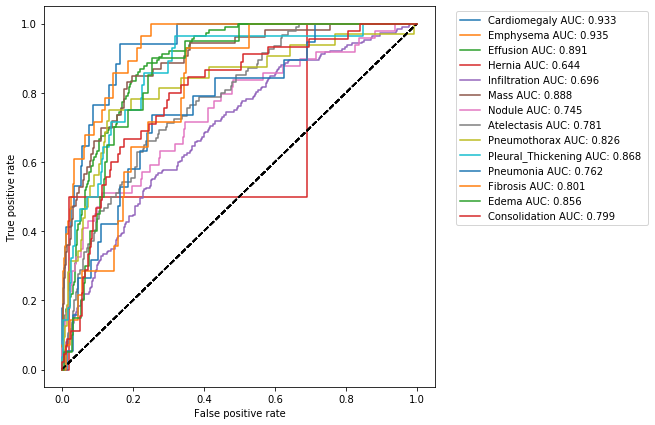

In [22]:
util.get_curve(y, pred, class_labels)

The area under the ROC curve is also called AUCROC or C-statistic and is a measure of goodness of fit. In medical literature this number also gives the probability that a randomly selected patient who experienced a condition had a higher risk score than a patient who had not experienced the event. This summarizes the model output across all thresholds, and provides a good sense of the discriminative power of a given model.

Let's use the `sklearn` metric function of `roc_auc_score` to add this score to our metrics table.

In [23]:
from sklearn.metrics import roc_auc_score
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,0.83,0.017,0.941,0.828,0.086,0.999,0.933,Not Defined,0.5
Emphysema,20,869,103,8,0.889,0.028,0.714,0.894,0.163,0.991,0.935,Not Defined,0.5
Effusion,99,690,196,15,0.789,0.114,0.868,0.779,0.336,0.979,0.891,Not Defined,0.5
Hernia,1,743,255,1,0.744,0.002,0.5,0.744,0.004,0.999,0.644,Not Defined,0.5
Infiltration,114,543,265,78,0.657,0.192,0.594,0.672,0.301,0.874,0.696,Not Defined,0.5
Mass,40,789,158,13,0.829,0.053,0.755,0.833,0.202,0.984,0.888,Not Defined,0.5
Nodule,28,731,220,21,0.759,0.049,0.571,0.769,0.113,0.972,0.745,Not Defined,0.5
Atelectasis,64,657,249,30,0.721,0.094,0.681,0.725,0.204,0.956,0.781,Not Defined,0.5
Pneumothorax,24,785,183,8,0.809,0.032,0.75,0.811,0.116,0.99,0.826,Not Defined,0.5


<a name='4'></a>
## 4. Confidence Intervals

Of course our dataset is only a sample of the real world, and our calculated values for all above metrics is an estimate of the real world values. It would be good to quantify this uncertainty due to the sampling of our dataset. We'll do this through the use of confidence intervals. A 95\% confidence interval for an estimate $\hat{s}$ of a parameter $s$ is an interval $I = (a, b)$ such that 95\% of the time when the experiment is run, the true value $s$ is contained in $I$. More concretely, if we were to run the experiment many times, then the fraction of those experiments for which $I$ contains the true parameter would tend towards 95\%.

While some estimates come with methods for computing the confidence interval analytically, more complicated statistics, such as the AUC for example, are difficult. For these we can use a method called the *bootstrap*. The bootstrap estimates the uncertainty by resampling the dataset with replacement. For each resampling $i$, we will get a new estimate, $\hat{s}_i$. We can then estimate the distribution of $\hat{s}$ by using the distribution of $\hat{s}_i$ for our bootstrap samples.

In the code below, we create bootstrap samples and compute sample AUCs from those samples. Note that we use stratified random sampling (sampling from the positive and negative classes separately) to make sure that members of each class are represented. 

In [24]:
def bootstrap_auc(y, pred, classes, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))

    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = roc_auc_score(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

statistics = bootstrap_auc(y, pred, class_labels)

Now we can compute confidence intervals from the sample statistics that we computed.

In [25]:
util.print_confidence_intervals(class_labels, statistics)

,Mean AUC (CI 5%-95%)
Cardiomegaly,0.93 (0.90-0.97)
Emphysema,0.93 (0.91-0.95)
Effusion,0.89 (0.87-0.91)
Hernia,0.65 (0.30-0.98)
Infiltration,0.70 (0.66-0.73)
Mass,0.89 (0.85-0.92)
Nodule,0.74 (0.69-0.81)
Atelectasis,0.78 (0.75-0.81)
Pneumothorax,0.82 (0.75-0.89)
Pleural_Thickening,0.87 (0.81-0.93)


As you can see, our confidence intervals are much wider for some classes than for others. Hernia, for example, has an interval around (0.30 - 0.98), indicating that we can't be certain it is better than chance (at 0.5). 

<a name='5'></a>
## 5. Precision-Recall Curve


Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. 

In information retrieval
- Precision is a measure of result relevancy and that is equivalent to our previously defined PPV. 
- Recall is a measure of how many truly relevant results are returned and that is equivalent to our previously defined sensitivity measure.

The precision-recall curve (PRC) shows the trade-off between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. 

High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Run the following cell to generate a PRC:

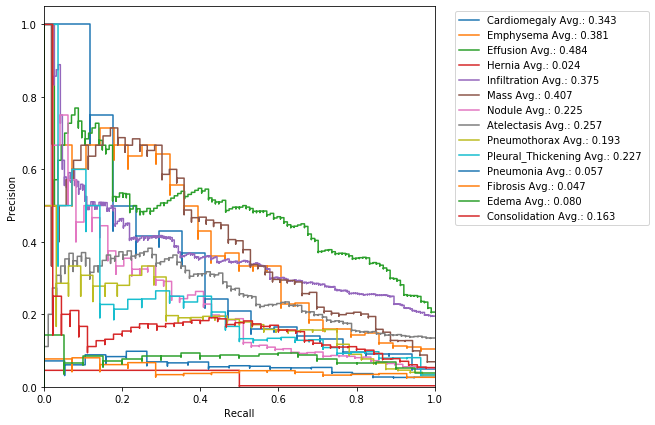

In [26]:
util.get_curve(y, pred, class_labels, curve='prc')

<a name='6'></a>
## 6. F1 Score

F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. 

Again, we can simply use `sklearn`'s utility metric function of `f1_score` to add this measure to our performance table.

In [27]:
from sklearn.metrics import f1_score
util.get_performance_metrics(y, pred, class_labels, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Cardiomegaly,16,814,169,1,0.83,0.017,0.941,0.828,0.086,0.999,0.933,0.158,0.5
Emphysema,20,869,103,8,0.889,0.028,0.714,0.894,0.163,0.991,0.935,0.265,0.5
Effusion,99,690,196,15,0.789,0.114,0.868,0.779,0.336,0.979,0.891,0.484,0.5
Hernia,1,743,255,1,0.744,0.002,0.5,0.744,0.004,0.999,0.644,0.008,0.5
Infiltration,114,543,265,78,0.657,0.192,0.594,0.672,0.301,0.874,0.696,0.399,0.5
Mass,40,789,158,13,0.829,0.053,0.755,0.833,0.202,0.984,0.888,0.319,0.5
Nodule,28,731,220,21,0.759,0.049,0.571,0.769,0.113,0.972,0.745,0.189,0.5
Atelectasis,64,657,249,30,0.721,0.094,0.681,0.725,0.204,0.956,0.781,0.314,0.5
Pneumothorax,24,785,183,8,0.809,0.032,0.75,0.811,0.116,0.99,0.826,0.201,0.5


<a name='7'></a>
## 7. Calibration

When performing classification we often want not only to predict the class label, but also obtain a probability of each label. This probability would ideally give us some kind of confidence on the prediction. In order to observe how our model's generated probabilities are aligned with the real probabilities, we can plot what's called a *calibration curve*. 

In order to generate a calibration plot, we first bucketize our predictions to a fixed number of separate bins (e.g. 5) between 0 and 1. We then calculate a point for each bin: the x-value for each point is the mean for the probability that our model has assigned to these points and the y-value for each point fraction of true positives in that bin. We then plot these points in a linear plot. A well-calibrated model has a calibration curve that almost aligns with the y=x line.

The `sklearn` library has a utility `calibration_curve` for generating a calibration plot. Let's use it and take a look at our model's calibration:

In [28]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(class_labels)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(class_labels[i])
    plt.tight_layout()
    plt.show()

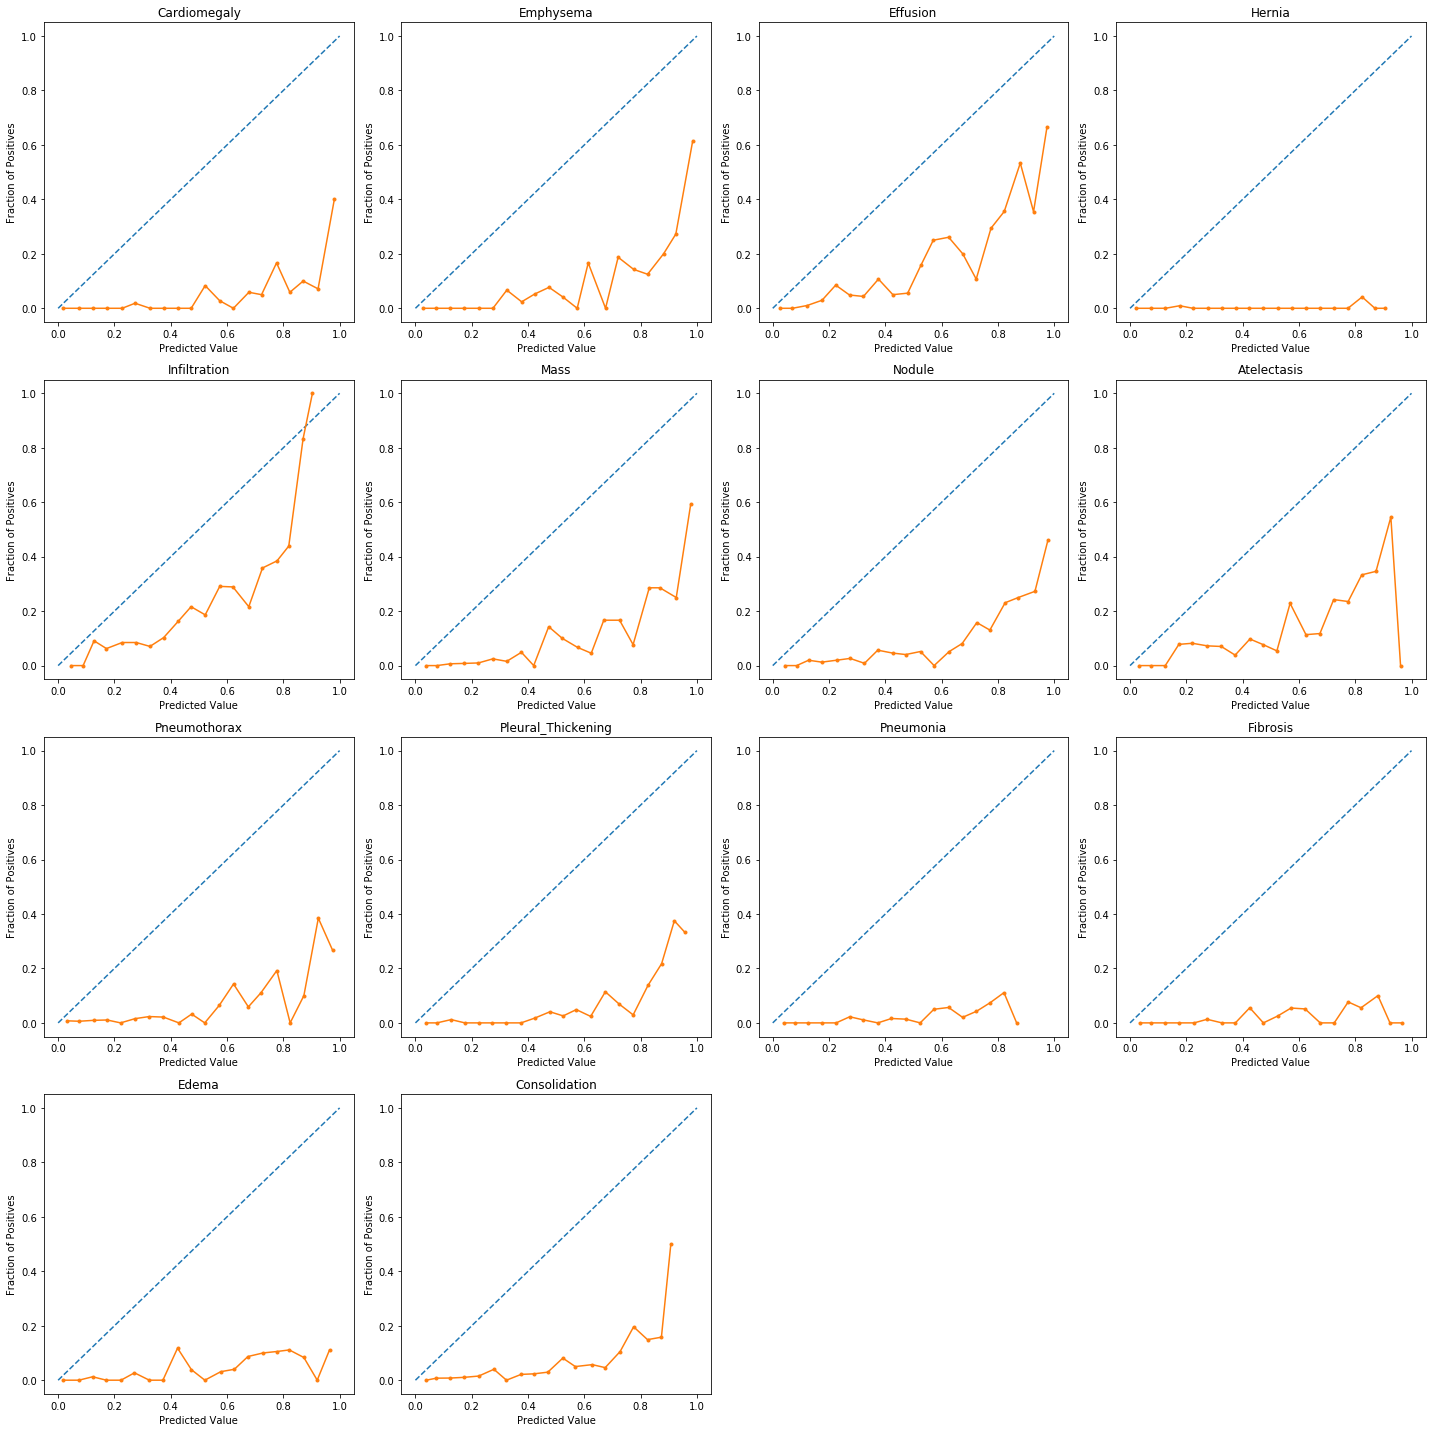

In [29]:
plot_calibration_curve(y, pred)

As the above plots show, for most predictions our model's calibration plot does not resemble a well calibrated plot. How can we fix that?...

Thankfully, there is a very useful method called [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) which works by fitting a logistic regression model to our model's scores. To build this model, we will be using the training portion of our dataset to generate the linear model and then will use the model to calibrate the predictions for our test portion.

In [30]:
from sklearn.linear_model import LogisticRegression as LR 

y_train = train_results[class_labels].values
pred_train = train_results[pred_labels].values
pred_calibrated = np.zeros_like(pred)

for i in range(len(class_labels)):
    lr = LR(solver='liblinear', max_iter=10000)
    lr.fit(pred_train[:, i].reshape(-1, 1), y_train[:, i])    
    pred_calibrated[:, i] = lr.predict_proba(pred[:, i].reshape(-1, 1))[:,1]

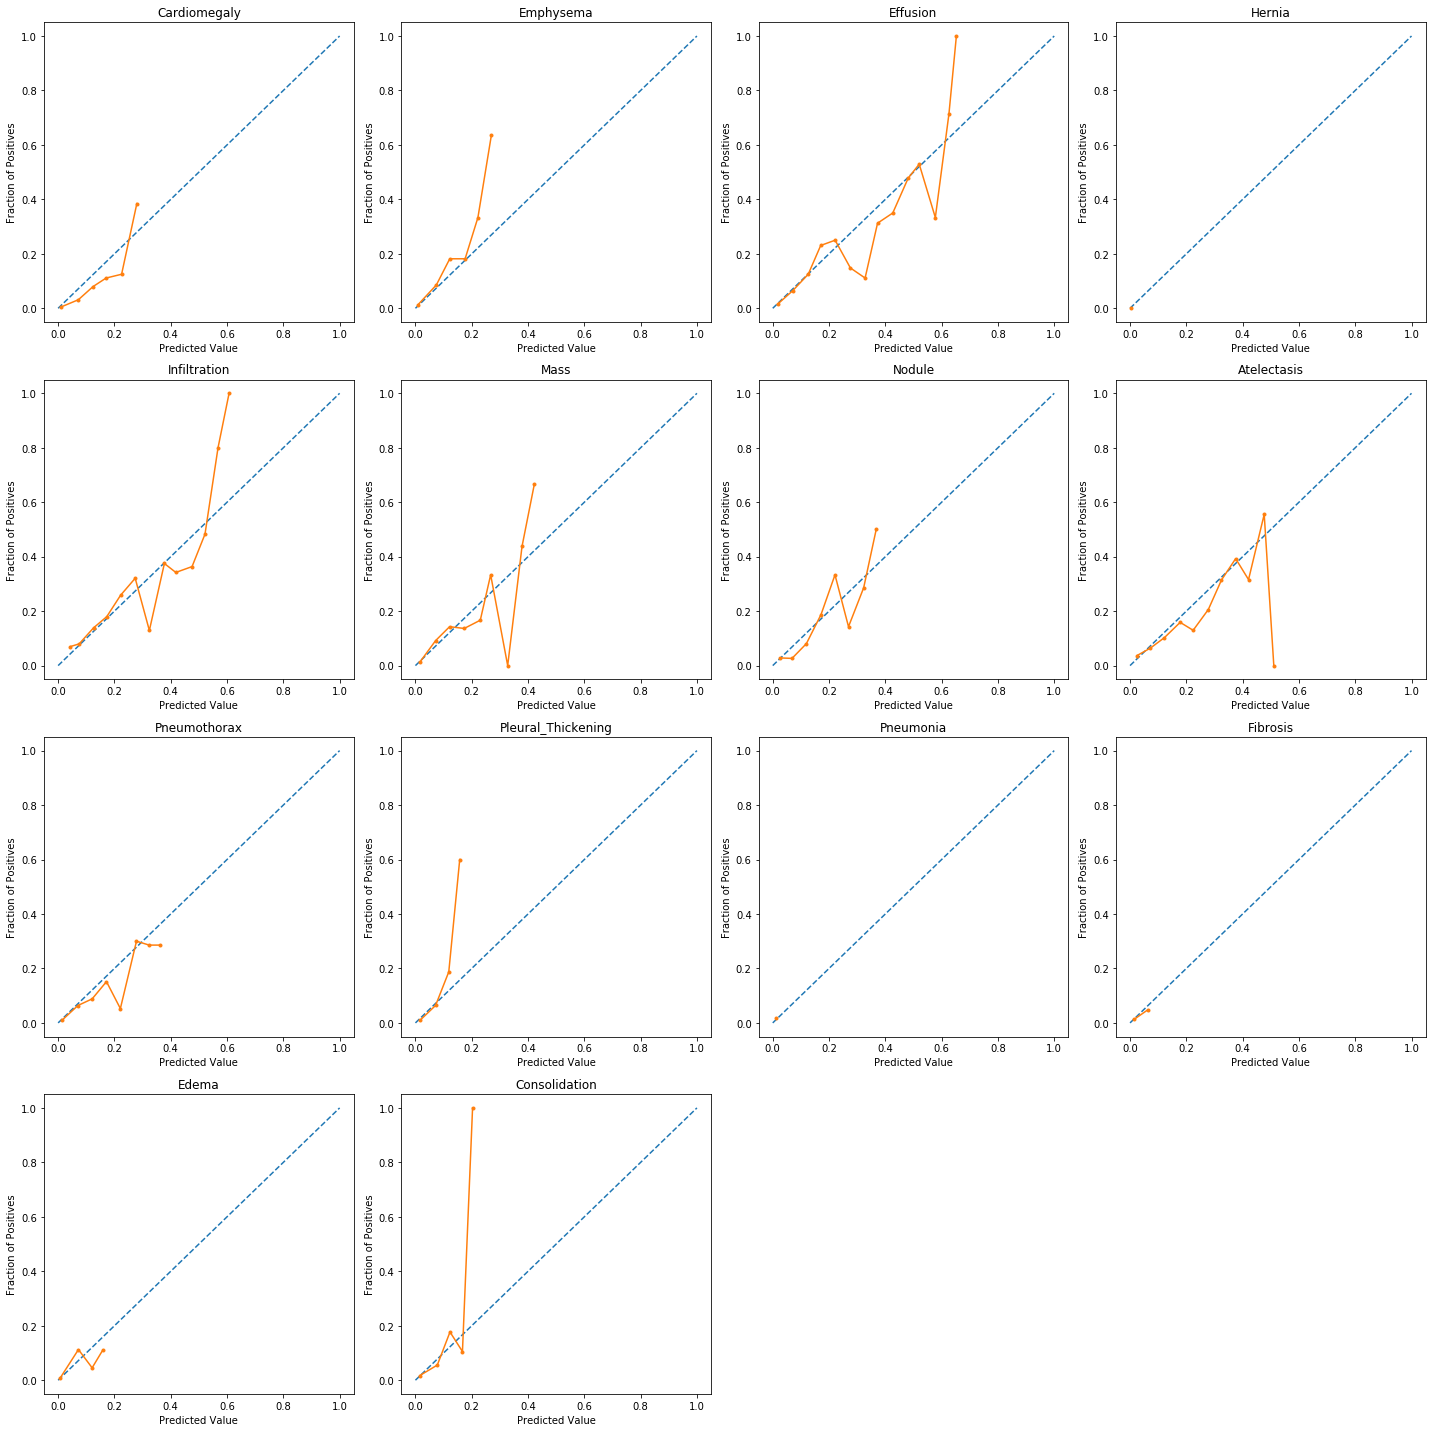

In [31]:
plot_calibration_curve(y[:,], pred_calibrated)

# That's it!
Congratulations! That was a lot of metrics to get familiarized with. 
We hope that you feel a lot more confident in your understanding of medical diagnostic evaluation and test your models correctly in your future work :)